![](img/330-banner.png)

# Lecture 9: Classification Metrics

UBC 2022 Summer

Instructor: Mehrdad Oveisi

## Imports

In [1]:
import os
import sys

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

In [2]:
# Changing global matplotlib settings for confusion matrix.
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18

## Learning outcomes 

From this lecture, students are expected to be able to:

- Explain why accuracy is not always the best metric in ML.
- Explain components of a confusion matrix. 
- Define precision, recall, and f1-score and use them to evaluate different classifiers. 
- Broadly explain macro-average, weighted average.
- Interpret and use precision-recall curves. 
- Explain average precision score.
- Interpret and use ROC curves and ROC AUC using `scikit-learn`.  
- Identify whether there is class imbalance and whether you need to deal with it.
- Explain and use `class_weight` to deal with data imbalance.

<br><br><br><br>

## Evaluation metrics for binary classification: Motivation 

### Dataset for demonstration 

- Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.

In [3]:
cc_df = pd.read_csv("data/creditcard.csv", encoding="latin-1")
train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
64454,51150.0,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,-2.939006,2.578654,...,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966,1.00,0
37906,39163.0,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,-0.972440,0.033833,...,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103,18.49,0
79378,57994.0,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,-0.016918,0.781531,...,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039,23.74,0
245686,152859.0,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,0.234040,0.550616,...,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296,156.52,0
60943,49575.0,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,-0.118450,0.469383,...,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782,57.50,0


In [4]:
train_df.shape

(199364, 31)

- Good size dataset 
- For confidentially reasons, it only provides transformed features with PCA, which is a popular dimensionality reduction technique. 

### Exploratory Data Analysis (EDA)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199364 entries, 64454 to 129900
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    199364 non-null  float64
 1   V1      199364 non-null  float64
 2   V2      199364 non-null  float64
 3   V3      199364 non-null  float64
 4   V4      199364 non-null  float64
 5   V5      199364 non-null  float64
 6   V6      199364 non-null  float64
 7   V7      199364 non-null  float64
 8   V8      199364 non-null  float64
 9   V9      199364 non-null  float64
 10  V10     199364 non-null  float64
 11  V11     199364 non-null  float64
 12  V12     199364 non-null  float64
 13  V13     199364 non-null  float64
 14  V14     199364 non-null  float64
 15  V15     199364 non-null  float64
 16  V16     199364 non-null  float64
 17  V17     199364 non-null  float64
 18  V18     199364 non-null  float64
 19  V19     199364 non-null  float64
 20  V20     199364 non-null  float64
 21  V21   

In [6]:
train_df.describe(include="all")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,94888.815669,0.000492,-0.000726,0.000927,0.000630,0.000036,0.000011,-0.001286,-0.002889,-0.000891,...,0.001205,0.000155,-0.000198,0.000113,0.000235,0.000312,-0.000366,0.000227,88.164679,0.001700
std,47491.435489,1.959870,1.645519,1.505335,1.413958,1.361718,1.327188,1.210001,1.214852,1.096927,...,0.748510,0.726634,0.628139,0.605060,0.520857,0.481960,0.401541,0.333139,238.925768,0.041201
min,0.000000,-56.407510,-72.715728,-31.813586,-5.683171,-42.147898,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-8.887017,-44.807735,-2.824849,-10.295397,-2.241620,-22.565679,-11.710896,0.000000,0.000000
25%,54240.000000,-0.918124,-0.600193,-0.892476,-0.847178,-0.691241,-0.768512,-0.553979,-0.209746,-0.642965,...,-0.227836,-0.541795,-0.162330,-0.354604,-0.317761,-0.326730,-0.070929,-0.052819,5.640000,0.000000
50%,84772.500000,0.018854,0.065463,0.179080,-0.019531,-0.056703,-0.275290,0.040497,0.022039,-0.052607,...,-0.029146,0.007666,-0.011678,0.041031,0.016587,-0.052790,0.001239,0.011234,22.000000,0.000000
75%,139349.250000,1.315630,0.803617,1.028023,0.744201,0.610407,0.399827,0.570449,0.327408,0.597326,...,0.186899,0.529210,0.146809,0.439209,0.351366,0.242169,0.090453,0.078052,77.150000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.491217,34.801666,23.917837,44.054461,19.587773,15.594995,...,27.202839,10.503090,22.083545,4.022866,6.070850,3.517346,12.152401,33.847808,11898.090000,1.000000


- We do not have categorical features. All features are numeric. 
- We have to be careful about the `Time` and `Amount` features. 
- We could scale `Amount`. 
- Do we want to scale time?
    - In this lecture we'll do it's probably not the best thing to do. 
    - We'll learn about time series briefly later in the course. 

Let's separate `X` and `y` for train and test splits.

In [7]:
X_train_big, y_train_big = train_df.drop(columns=["Class"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class"]), test_df["Class"]

- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. 
- So let's create a validation set. 
- Our data is large enough so it shouldn't be a problem. 


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

### Baseline

In [9]:
dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

fit_time       0.026209
score_time     0.002659
test_score     0.998302
train_score    0.998302
dtype: float64

### Observations 

- `DummyClassifier` is getting 0.998 cross-validation accuracy!! 
- Should we be happy with this accuracy and deploy this `DummyClassifier` model for fraud detection? 

What's the class distribution? 

In [10]:
train_df["Class"].value_counts()

0    199025
1       339
Name: Class, dtype: int64

In [11]:
train_df["Class"].value_counts(normalize=True)

0    0.9983
1    0.0017
Name: Class, dtype: float64

- We have class imbalance. 
- We have MANY non-fraud transactions and only a handful of fraud transactions. 
- So in the training set, `most_frequent` strategy is labeling 199,025 (99.83%) instances correctly and only 339 (0.17%) instances incorrectly. 
- Is this what we want? 
- The "fraud" class is the important class that we want to spot. 

Let's scale the features and try `LogisticRegression`.   

In [12]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.936949
score_time     0.013698
test_score     0.999176
train_score    0.999249
dtype: float64

- We are getting a slightly better score with logistic regression.  
- What score should be considered an **acceptable score** here? 
- Are we actually spotting any "fraud" transactions? 

- `.score` by default returns accuracy which is 
$$accuracy = \frac{correct\ predictions}{total\ examples}$$
- Is accuracy a good metric here? 
- Is there anything more informative than accuracy that we can use here? 

Let's dig a little deeper.

<br><br><br><br>

## Confusion matrix

One way to get a better understanding of the errors is by looking at 
- false positives (type I errors), where the model incorrectly spots examples as fraud
- false negatives (type II errors), where it's missing to spot fraud examples 

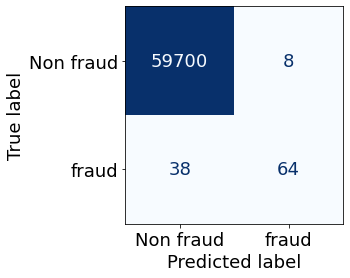

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.rc('font', size=18)

pipe.fit(X_train, y_train)
disp = ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
    colorbar=False,
)

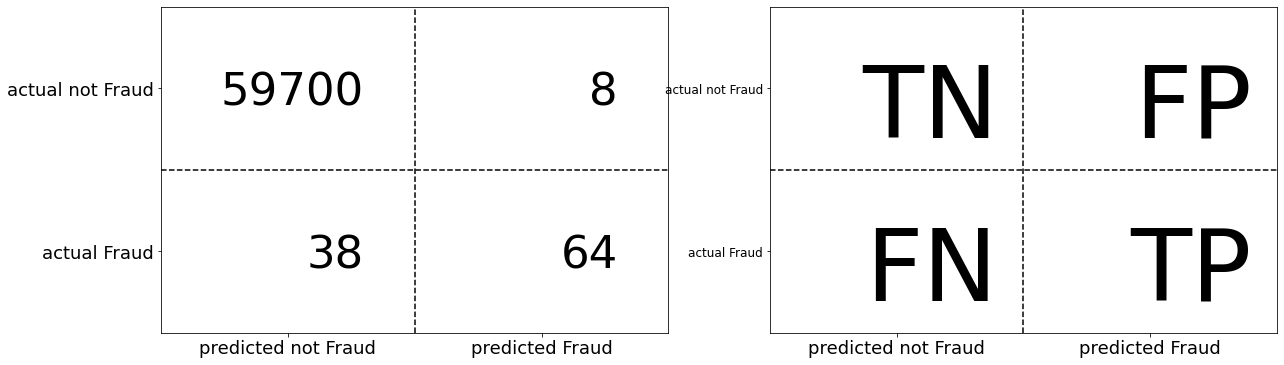

In [14]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
plot_confusion_matrix_example(TN, FP, FN, TP)

- **Perfect** prediction has all values **down the diagonal**
- **Off diagonal** entries can often tell us about what is being **mis-predicted**

### What is "positive" and "negative"?

- Two kinds of binary classification problems 
    - Distinguishing between two classes
    - **Spotting** a class (spot fraud transaction, spot spam, spot disease)
- In case of spotting problems, the thing that we are interested in spotting is considered "**positive**".
- Above we wanted to spot fraudulent transactions and so they are "positive". 

You can get a numpy array of confusion matrix, and you can *unpack* it into its elements using numpy `ravel()` as follows:

In [15]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)  # note that pipe must have already been fitted using train data
cm = confusion_matrix(y_valid, predictions)
TN, FP, FN, TP = cm.ravel()  # unpack cm elements
TN, FP, FN, TP

(59700, 8, 38, 64)

In [16]:
print("Confusion matrix for fraud dataset:\n", cm)

Confusion matrix for fraud dataset:
 [[59700     8]
 [   38    64]]


### Confusion matrix with cross-validation 

- You can also calculate confusion matrix with cross-validation using the `cross_val_predict` method.
- Then you need to use `ConfusionMatrixDisplay.`**`from_predictions`** to draw confusion matrix.

In [17]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([[139296,     21],
       [    94,    143]])

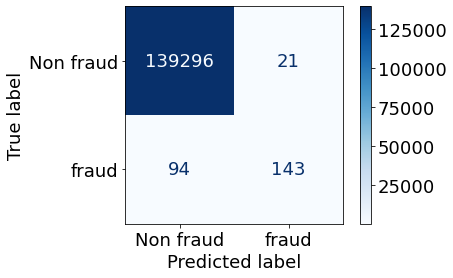

In [18]:
ConfusionMatrixDisplay.from_predictions(
    y_train,
    cross_val_predict(pipe, X_train, y_train),
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

<br><br><br><br>

## Precision, recall, f1 score 

- We have been using `.score` to assess our models, which returns **accuracy by default**.
- Accuracy is misleading when we have class imbalance.
- We need other metrics to assess our models.

- We'll discuss three commonly used metrics which are **based on confusion matrix**:
    - *recall*
    - *precision*
    - *f1 score*
- Note that these metrics will only help us **assessing** our model.
- Later we'll talk about a few ways to address class imbalance problem.

In [19]:
from sklearn.metrics import confusion_matrix

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
predictions = pipe_lr.predict(X_valid)
cm = confusion_matrix(y_valid, predictions)
TN, FP, FN, TP = cm.ravel()
print("TN, FP, FN, TP:", TN, FP, FN, TP, '\n')
cm

TN, FP, FN, TP: 59700 8 38 64 



array([[59700,     8],
       [   38,    64]])

### Recall 

Among all positive examples, how many did you identify?
$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

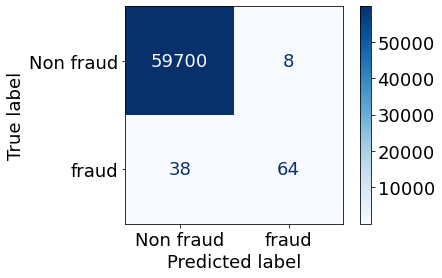

In [20]:
ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

In [21]:
print("TP = %0.4f, FN = %0.4f" % (TP, FN))
recall = TP / (TP + FN)
print("Recall: %0.4f" % (recall))

TP = 64.0000, FN = 38.0000
Recall: 0.6275


### Precision 

Among the positive examples you identified, how many were actually positive?

$$ precision = \frac{TP}{TP+FP}$$

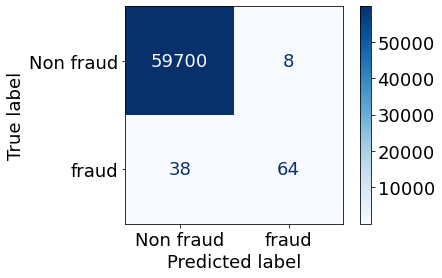

In [22]:
ConfusionMatrixDisplay.from_estimator(
    pipe,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

In [23]:
print("TP = %0.4f, FP = %0.4f" % (TP, FP))
precision = TP / (TP + FP)
print("Precision: %0.4f" % (precision))

TP = 64.0000, FP = 8.0000
Precision: 0.8889


### F1-score

- F1-score **combines precision and recall** to give one score, which could be used in hyperparameter optimization, for instance.
- F1-score is a harmonic mean of precision and recall. 


$$ f1 = 2 \times \frac{ precision \times recall}{precision + recall}$$


In [24]:
print("precision: %0.4f" % (precision))
print("recall: %0.4f" % (recall))
f1_score = (2 * precision * recall) / (precision + recall)
print("f1: %0.4f" % (f1_score))

precision: 0.8889
recall: 0.6275
f1: 0.7356


Let's look at all metrics at once on our dataset.

In [25]:
## Calculate evaluation metrics by ourselves
data = {
    "calculation": [],
    "accuracy": [],
    "error": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}
data["calculation"].append("manual")
data["accuracy"].append((TP + TN) / (TN + FP + FN + TP))
data["error"].append((FP + FN) / (TN + FP + FN + TP))
data["precision"].append(precision)  # TP / (TP + FP)
data["recall"].append(recall)  # TP / (TP + FN)
data["f1 score"].append(f1_score)  # (2 * precision * recall) / (precision + recall)
df = pd.DataFrame(data)
df

,calculation,accuracy,error,precision,recall,f1 score
0,manual,0.999231,0.000769,0.888889,0.627451,0.735632


- `scikit-learn` has functions for [these metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [26]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(
    precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1)
)
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
data["calculation"].append("sklearn")
df = pd.DataFrame(data)
df.set_index(["calculation"])

,accuracy,error,precision,recall,f1 score
calculation,,,,,
manual,0.999231,0.000769,0.888889,0.627451,0.735632
sklearn,0.999231,0.000769,0.888889,0.627451,0.735632


The scores match. 

### Classification report 

- There is a convenient function called `classification_report` in `sklearn` which gives this info. 

In [27]:
pipe_lr.classes_

array([0, 1])

In [28]:
from sklearn.metrics import classification_report

print("y_valid, not fraud:", len(y_valid) - y_valid.sum())
print("y_valid, fraud:      ", y_valid.sum())
print("X_valid, total:    ", X_valid.shape[0], "\n\n")

print(
    classification_report(
        y_valid, pipe_lr.predict(X_valid), target_names=["non-fraud", "fraud"]
    )
)

y_valid, not fraud: 59708
y_valid, fraud:       102
X_valid, total:     59810 


              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



### Macro average

- You give **equal importance** to all classes and average over all classes.  
- For instance, in the example above, recall for non-fraud is 1.0 and fraud is 0.63, and so macro average is 0.81. 
- More relevant in case of **multi-class** problems.

### Weighted average

- Weighted by the number of samples in each class. 
- Divide by the total number of samples.

<br>
Which one is relevant depends upon whether you think:

- each class should have the same weight or 
- each sample should have the same weight. 

### Interim summary 

- **Accuracy** is misleading when you have class **imbalance**.
- A **confusion matrix** provides a way to **break down errors** made by our model.
- We looked at three metrics based on confusion matrix: 
    - precision, recall, f1-score. 

- Note that what you consider "positive" (fraud in our case) is important when calculating precision, recall, and f1-score. 
- If you flip what is considered positive or negative, we'll end up with different TP, FP, TN, FN, and hence different precision, recall, and f1-scores. 

### Evalution metrics overview  
There is a lot of terminology here. 

<img src='./img/evaluation-metrics.png' width="1000" height="1000" />

### Cross validation with different metrics

- We can pass different evaluation metrics with `scoring` argument of `cross_validate`.

In [29]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(
    pipe, X_train_big, y_train_big, return_train_score=True, scoring=scoring
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,1.950375,0.084050,0.999147,0.999367,0.711864,0.783726,0.617647,0.675277,0.840000,0.933673
1,0.989792,0.076899,0.999298,0.999329,0.766667,0.770878,0.676471,0.664207,0.884615,0.918367
2,0.895264,0.048741,0.999273,0.999216,0.743363,0.726477,0.617647,0.612546,0.933333,0.892473
3,0.926056,0.070173,0.999172,0.999279,0.697248,0.753747,0.558824,0.649446,0.926829,0.897959
4,0.904787,0.058483,0.999172,0.999223,0.702703,0.731602,0.582090,0.621324,0.886364,0.889474


- You can also create [your own scoring function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and pass it to `cross_validate`. 

### ❓❓ Questions for you

### True/False questions: decision theory, evaluation metrics

1. In medical diagnosis, false positives are more damaging than false negatives (assume "positive" means the person has a disease, "negative" means they don't).
2. In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means they it's not).
3. In the medical diagnosis, high recall is more important than high precision.
4. If method A gets a higher accuracy than method B, that means its precision is also higher.
5. If method A gets a higher accuracy than method B, that means its recall is also higher.

Method A - higher accuracy but lower precision

| Negative | Positive
| -------- |:-------------:|
| 90      | 5|
| 5      | 0|

Method B - lower accuracy but higher precision

| Negative | Positive
| -------- |:-------------:|
| 80      | 15|
| 0      | 5|




<br><br><br><br>

## Precision-recall curve and ROC curve

- Confusion matrix provides a detailed break down of the errors made by the model. 
- But when creating a confusion matrix, we are using "hard" predictions. 
- Most classifiers in `scikit-learn` provide `predict_proba` method (or `decision_function`) which provides degree of certainty about predictions by the classifier. 
- Can we explore the degree of uncertainty to understand and improve the model performance? 

Let's revisit the classification report on our fraud detection example. 

In [30]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train);

In [31]:
y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



By default, predictions use the threshold of 0.5. If `predict_proba` > 0.5, predict "fraud" else predict "non-fraud".

In [32]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > 0.50
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



- Suppose for your business it is more costly to miss fraudulent transactions and you want to achieve a recall of at least 75% for the "fraud" class. 
- One way to do this is by changing the threshold of `predict_proba`.
    - `predict` returns 1 when `predict_proba`'s probabilities are above 0.5 for the "fraud" class.

**Key idea: what if we threshold the probability at a smaller value so that we identify more examples as "fraud" examples?** 

Let's lower the threshold to 0.1. In other words, predict the examples as "fraud" if `predict_proba` > 0.1.  

In [33]:
y_pred_lower_threshold = pipe_lr.predict_proba(X_valid)[:, 1] > 0.1

In [34]:
print(classification_report(y_valid, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59708
           1       0.78      0.76      0.77       102

    accuracy                           1.00     59810
   macro avg       0.89      0.88      0.89     59810
weighted avg       1.00      1.00      1.00     59810



### Operating point 

- Now our recall for "fraud" class is >= 0.75. 
- Setting a requirement on a classifier (e.g., recall of >= 0.75) is called setting the **operating point**. 
- It's usually driven by business goals and is useful to make performance guarantees to customers. 

### Precision/Recall tradeoff 

- But there is a trade-off between precision and recall. 
- If you identify more things as "fraud", recall is going to increase but there are likely to be more false positives. 

Let's sweep through different thresholds. 

In [35]:
thresholds = np.arange(0.0, 1.0, 0.1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [36]:
pr_dict = {"threshold": [], "precision": [], "recall": [], "f1 score": []}
for threshold in thresholds:
    preds = pipe_lr.predict_proba(X_valid)[:, 1] > threshold
    pr_dict["threshold"].append(threshold)
    pr_dict["precision"].append(precision_score(y_valid, preds))
    pr_dict["recall"].append(recall_score(y_valid, preds))
    pr_dict["f1 score"].append(f1_score(y_valid, preds))

In [37]:
pd.DataFrame(pr_dict)

,threshold,precision,recall,f1 score
0,0.0,0.001705,1.000000,0.003405
1,0.1,0.780000,0.764706,0.772277
2,0.2,0.795699,0.725490,0.758974
3,0.3,0.819277,0.666667,0.735135
4,0.4,0.876712,0.627451,0.731429
5,0.5,0.888889,0.627451,0.735632
6,0.6,0.897059,0.598039,0.717647
7,0.7,0.892308,0.568627,0.694611
8,0.8,0.901639,0.539216,0.674847
9,0.9,0.894737,0.500000,0.641509


### Decreasing the threshold

- Decreasing the threshold means a lower bar for predicting fraud. 
    - You are willing to risk more false positives in exchange of more true positives. 
    - recall would either stay the same or go up and precision is likely to go down
    - occasionally, precision may increase if all the new examples after decreasing the threshold are TPs. 

### Increasing the threshold

- Increasing the threshold means a higher bar for predicting fraud. 
    - recall would go down or stay the same but precision is likely to go up 
    - occasionally, precision may go down as the denominator for precision is TP+FP.    

### Precision-recall curve

Often, when developing a model, it's not always clear what the operating point will be and to understand the the model better, it's informative to look at all possible thresholds and corresponding trade-offs of precision and recall in a plot.  


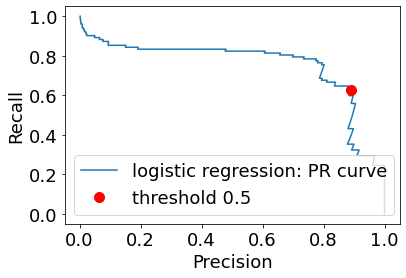

In [38]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_valid, pipe_lr.predict_proba(X_valid)[:, 1]
)
plt.plot(precision, recall, label="logistic regression: PR curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.plot(
    precision_score(y_valid, pipe_lr.predict(X_valid)),
    recall_score(y_valid, pipe_lr.predict(X_valid)),
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

- Each point in the curve corresponds to a possible threshold of the `predict_proba` output. 
- We can achieve a recall of 0.8 at a precision of 0.4. 
- The red dot marks the point corresponding to the threshold 0.5.
- The top-right would be a perfect classifier (precision = recall = 1).

- The threshold is not shown here, but it's going from 0 (upper-left) to 1 (lower right).
- At a threshold of 0 (upper left), we are classifying everything  as "fraud".
- Raising the threshold increases the precision but at the expense of lowering the recall. 
- At the extreme right, where the threshold is 1, we get into the situation where all the examples classified as "fraud" are actually "fraud"; we have no false positives. 
- Here we have a high precision but lower recall. 
- Usually the goal is to keep recall high as precision goes up. 

### A few comments on PR curve

- Different classifiers might work well in different parts of the curve, i.e., at different operating points.   
- We can compare PR curves of different classifiers to understand these differences. 

### AP score 

- Often it's useful to have one number summarizing the PR plot (e.g., in hyperparameter optimization)
- One way to do this is by computing the area under the PR curve. 
- This is called **average precision** (AP score)
- AP score has a value between 0 (worst) and 1 (best). 

In [39]:
from sklearn.metrics import average_precision_score

ap_lr = average_precision_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
print("Average precision of logistic regression: {:.3f}".format(ap_lr))

Average precision of logistic regression: 0.757


### AP vs. F1-score

It is very important to note this distinction:

- F1 score is for a given threshold and measures the quality of `predict`.
- AP score is a summary across thresholds and measures the quality of `predict_proba`.


***Important***
Remember to pick the desired threshold based on the results on the validation set and **not** on the test set.

<br><br>

### Receiver Operating Characteristic (ROC) curve 

- Another commonly used tool to analyze the behavior of classifiers at different thresholds.  
- Similar to PR curve, it considers all possible thresholds for a given classifier given by `predict_proba` but instead of precision and recall it plots false positive rate (FPR) and true positive rate (TPR or recall).
$$ FPR  = \frac{FP}{FP + TN}, TPR = \frac{TP}{TP + FP}$$


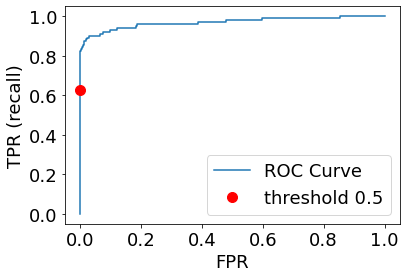

In [40]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

- The ideal curve is close to the top left
    - Ideally, you want a classifier with high recall while keeping low false positive rate.  


- The red dot corresponds to the threshold of 0.5, which is used by predict.

### Area under the curve (AUC)

- AUC provides a single meaningful number for the model performance. 

In [41]:
from sklearn.metrics import roc_auc_score

roc_lr = roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
print("AUC for SVC: {:.3f}".format(roc_lr))

AUC for SVC: 0.969


- AUC of 0.5 means random chance. 
- AUC can be interpreted as evaluating the **ranking** of positive examples.
- What's the probability that a randomly picked positive point has a higher score according to the classifier than a randomly picked point from the negative class. 
- AUC of 1.0 means all positive points have a higher score than all negative points. 

***Important***
For classification problems with imbalanced classes, using AP score or AUC is often much more meaningful than using accuracy.

### Let's look at all the scores at once

In [42]:
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(pipe, X_train_big, y_train_big, scoring=scoring)
pd.DataFrame(scores).mean()

fit_time                  1.403801
score_time                0.162559
test_accuracy             0.999212
test_f1                   0.724369
test_recall               0.610536
test_precision            0.894228
test_roc_auc              0.967438
test_average_precision    0.744030
dtype: float64

***See Also***
Check out [these visualization](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation) on ROC and AUC.

<br><br><br><br>

## Dealing with class imbalance

### Class imbalance in training sets

- This typically refers to having many more examples of one class than another in one's training set.
- Real world data is often imbalanced. 
    - Our Credit Card Fraud dataset is imbalanced.
    - Ad clicking data is usually drastically imbalanced. (Only around ~0.01% ads are clicked.)
    - Spam classification datasets are also usually imbalanced.

### Addressing class imbalance
A very important question to ask yourself: "Why do I have a class imbalance?"

- Is it because one class is much more rare than the other?
    - If it's just because one is more rare than the other, you need to ask whether you care about one type of error more than the other.    
- Is it because of my data collection methods?
    - If it's the data collection, then that means _your test and training data come from different distributions_!
  
In some cases, it may be fine to just ignore the class imbalance.

### Which type of error is more important? 

- False positives (FPs) and false negatives (FNs) have quite different real-world consequences. 
- In PR curve and ROC curve, we saw how changing the prediction threshold can change FPs and FNs. 
- We can then pick the threshold that's appropriate for our problem. 
- Example: if we want high recall, we may use a lower threshold (e.g., a threshold of 0.1). We'll then catch more fraudulent transactions. 

In [43]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.63      0.74       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.87     59810
weighted avg       1.00      1.00      1.00     59810



In [44]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > 0.10
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.78      0.76      0.77       102

    accuracy                           1.00     59810
   macro avg       0.89      0.88      0.89     59810
weighted avg       1.00      1.00      1.00     59810



### Handling imbalance

Can we change the model itself rather than changing the threshold so that it takes into account the errors that are important to us?

There are two common approaches for this: 
- **Changing the data (optional)** (not covered in this course)
   - Undersampling
   - Oversampling 
       - Random oversampling
       - SMOTE 
- **Changing the training procedure** 
    - `class_weight`

### Changing the training procedure 

- All `sklearn` classifiers have a parameter called `class_weight`.
- This allows you to specify that one class is more important than another.
- For example, maybe a false negative is 10x more problematic than a false positive. 

### Example: `class_weight` parameter of `sklearn LogisticRegression` 
> class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, **class_weight=None**, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

> class_weight: dict or 'balanced', default=None

> Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. 

In [45]:
from IPython.display import IFrame
url = "https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html"
IFrame(src=url, width=1200, height=600)

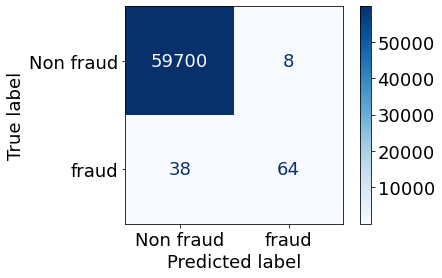

In [46]:
ConfusionMatrixDisplay.from_estimator(
    pipe_lr,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

In [47]:
pipe_lr.named_steps["logisticregression"].classes_

array([0, 1])

Let's set "fraud" class a weight of 10.

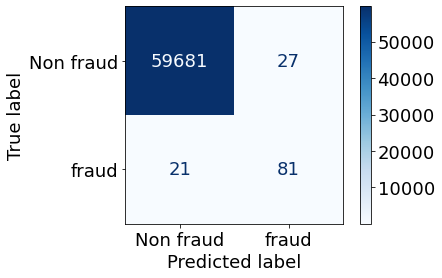

In [48]:
pipe_lr_weight = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight={0:1, 1: 10})
)
pipe_lr_weight.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(
    pipe_lr_weight,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

- Notice we've reduced false negatives and predicted more Fraud this time.
- This was equivalent to saying give 10x more "importance" to fraud class. 
- Note that as a consequence we are also increasing false positives.    

### `class_weight="balanced"`
- A useful setting is `class_weight="balanced"`.
- This sets the weights so that the classes are "equal".

> class_weight: dict, ‘balanced’ or None
If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). If a dictionary is given, keys are classes and values are corresponding class weights. If None is given, the class weights will be uniform.

> sklearn.utils.class_weight.compute_class_weight(class_weight, classes, y)

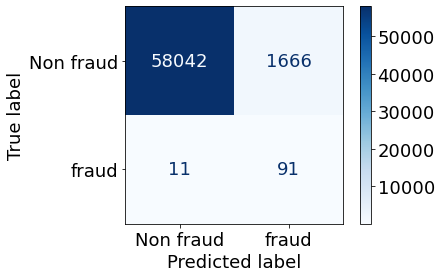

In [49]:
pipe_lr_balanced = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight="balanced")
)
pipe_lr_balanced.fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(
    pipe_lr_balanced,
    X_valid,
    y_valid,
    display_labels=["Non fraud", "fraud"],
    values_format="d",
    cmap=plt.cm.Blues,
);

We have reduced false negatives but we have many more false positives now ...

### Are we doing better with `class_weight="balanced"`?

In [50]:
comp_dict = {}
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=500))
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
orig_scores = cross_validate(pipe_lr, X_train_big, y_train_big, scoring=scoring)

In [51]:
pipe_lr_balanced = make_pipeline(
    StandardScaler(), LogisticRegression(max_iter=500, class_weight="balanced")
)
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
bal_scores = cross_validate(pipe_lr_balanced, X_train_big, y_train_big, scoring=scoring)
comp_dict = {
    "Original": pd.DataFrame(orig_scores).mean().tolist(),
    "class_weight='balanced'": pd.DataFrame(bal_scores).mean().tolist(),
}

In [52]:
pd.DataFrame(comp_dict, index=bal_scores.keys())

,Original,class_weight='balanced'
fit_time,0.997678,1.416901
score_time,0.101473,0.118384
test_accuracy,0.999212,0.973626
test_f1,0.724369,0.103831
test_recall,0.610536,0.896883
test_precision,0.894228,0.055119
test_roc_auc,0.967438,0.970881
test_average_precision,0.744030,0.730627


- Recall is much better but precision has dropped a lot; we have many false positives. 
- You could also optimize `class_weight` using hyperparameter optimization for your specific problem. 

- Changing the class weight will **generally reduce accuracy**.
- The original model was trying to maximize accuracy.
- Now you're telling it to do something different.
- But that can be fine, accuracy isn't the only metric that matters.

### Stratified Splits

- A similar idea of "balancing" classes can be applied to data splits.
- We have the same option in `train_test_split` with the `stratify` argument. 
- By default it splits the data so that if we have 10% negative examples in total, then each split will have 10% negative examples.

- If you are carrying out cross validation using `cross_validate`, by default it uses [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html). From the documentation: 

> This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

- In other words, if we have 10% negative examples in total, then each fold will have 10% negative examples.

### Is stratifying a good idea? 

  - Well, it's no longer a random sample, which is probably theoretically bad, but not that big of a deal.
  - If you have many examples, it shouldn't matter as much.
  - It can be especially useful in multi-class, say if you have one class with very few cases.
  - In general, these are difficult questions.

<br><br><br><br>

## What did we learn today? 

- A number of possible ways to evaluate machine learning models 
    - Choose the evaluation metric that makes most sense in your context or which is most common in your discipline  
- Two kinds of binary classification problems 
    - Distinguishing between two classes (e.g., dogs vs. cats)
    - Spotting a class (e.g., spot fraud transaction, spot spam)

- Precision, recall, f1-score are useful when dealing with spotting problems. 
- The thing that we are interested in spotting is considered "positive".   
- Do you need to deal with class imbalance in the given problem? 
- Methods to deal with class imbalance 
    - Changing the training procedure 
        - `class_weight`

### Relevant papers and resources 

- [The Relationship Between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)
- [Article claiming that PR curve are better than ROC for imbalanced datasets](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432)
- [Precision-Recall-Gain Curves: PR Analysis Done Right](https://papers.nips.cc/paper/2015/file/33e8075e9970de0cfea955afd4644bb2-Paper.pdf)
- [ROC animation](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation)
- [Generalization in Adaptive Data Analysis and Holdout Reuse](https://arxiv.org/pdf/1506.02629.pdf)